In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
%matplotlib inline
sns.set()
from dateutil.relativedelta import relativedelta 
from scipy.optimize import minimize              
import statsmodels.formula.api as smf            
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    
from tqdm import tqdm_notebook

import warnings                                
warnings.filterwarnings('ignore')


/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Read in data

In [2]:
path = r'rnd/2013-7/'                     # use your path
all_files = glob.glob(os.path.join(path, "*.csv"))     # advisable to use os.path.join as this makes concatenation OS independent
df_from_each_file = [pd.read_csv(fp, sep = ';\t').assign(VM=os.path.basename(fp).split('.')[0]) for fp in all_files]
concatenated_df   = pd.concat(df_from_each_file)

In [3]:
path = r'rnd/2013-8/'                     # use your path
all_files = glob.glob(os.path.join(path, "*.csv"))     # advisable to use os.path.join as this makes concatenation OS independent

df_from_each_file = [pd.read_csv(fp, sep = ';\t').assign(VM=os.path.basename(fp).split('.')[0]) for fp in all_files]
concatenated_df8   = pd.concat(df_from_each_file)

In [4]:
path = r'rnd/2013-9/'                     # use your path
all_files = glob.glob(os.path.join(path, "*.csv"))     # advisable to use os.path.join as this makes concatenation OS independent
df_from_each_file = [pd.read_csv(fp, sep = ';\t').assign(VM=os.path.basename(fp).split('.')[0]) for fp in all_files]
concatenated_df9   = pd.concat(df_from_each_file)

Check it out

In [5]:
concatenated_df.head()

,Timestamp [ms],CPU cores,CPU capacity provisioned [MHZ],CPU usage [MHZ],CPU usage [%],Memory capacity provisioned [KB],Memory usage [KB],Disk read throughput [KB/s],Disk write throughput [KB/s],Network received throughput [KB/s],Network transmitted throughput [KB/s],VM
0,1372629804,2,5851.9989,87.779984,1.500000,8218624.0,1.034593e+06,160.866667,21.733333,0.266667,1.466667,1
1,1372630104,2,5851.9989,29.259995,0.500000,8218624.0,4.585755e+05,0.000000,2.333333,0.200000,1.000000,1
2,1372630404,2,5851.9989,27.309328,0.466667,8218624.0,1.845480e+05,32.066667,4.200000,0.133333,1.066667,1
3,1372630704,2,5851.9989,23.407996,0.400000,8218624.0,7.829227e+04,0.000000,0.866667,0.066667,1.000000,1
4,1372631004,2,5851.9989,19.506663,0.333333,8218624.0,1.677720e+05,0.000000,0.200000,0.133333,1.000000,1


In [6]:
newdat = concatenated_df.append(concatenated_df8)
newerdat = newdat.append(concatenated_df9)
concatenated_df = newerdat

In [7]:
concatenated_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12496728 entries, 0 to 8302
Data columns (total 12 columns):
Timestamp [ms]                           int64
CPU cores                                int64
CPU capacity provisioned [MHZ]           float64
CPU usage [MHZ]                          float64
CPU usage [%]                            float64
Memory capacity provisioned [KB]         float64
Memory usage [KB]                        float64
Disk read throughput [KB/s]              float64
Disk write throughput [KB/s]             float64
Network received throughput [KB/s]       float64
Network transmitted throughput [KB/s]    float64
VM                                       object
dtypes: float64(9), int64(2), object(1)
memory usage: 1.2+ GB


## feature engineering and setting to timeseries
timestamp is in epochs

In [8]:
concatenated_df['Timestamp'] = pd.to_datetime(concatenated_df['Timestamp [ms]'], unit = 's')
#concatenated_df.apply(pd.to_numeric, errors='ignore')
#concatenated_df.describe()

In [9]:
concatenated_df['Timestamp'] = pd.to_datetime(concatenated_df['Timestamp [ms]'], unit = 's')
concatenated_df.apply(pd.to_numeric, errors='ignore')

concatenated_df['weekday'] = concatenated_df['Timestamp'].dt.dayofweek
concatenated_df['weekend'] = ((concatenated_df.weekday) // 5 == 1).astype(float)
concatenated_df['month']=concatenated_df.Timestamp.dt.month 
concatenated_df['day']=concatenated_df.Timestamp.dt.day

concatenated_df.set_index('Timestamp',inplace=True)

In [10]:
concatenated_df["CPU usage prev"] = concatenated_df['CPU usage [%]'].shift(1)

In [11]:
concatenated_df["CPU_diff"] = concatenated_df['CPU usage [%]'] - concatenated_df["CPU usage prev"]

In [12]:
concatenated_df["received_prev"] = concatenated_df['Network received throughput [KB/s]'].shift(1)
concatenated_df["received_diff"] = concatenated_df['Network received throughput [KB/s]']- concatenated_df["received_prev"]

concatenated_df["transmitted_prev"] = concatenated_df['Network transmitted throughput [KB/s]'].shift(1)
concatenated_df["transmitted_diff"] = concatenated_df['Network transmitted throughput [KB/s]']- concatenated_df["transmitted_prev"]

In [ ]:
#concatenated_df.info()

## Create hourlydat DF, which is the concatenated_df, resampled & aggregated over each hour.

In [ ]:
hourlydat = concatenated_df.resample('H').sum()
#hourlydat.iloc[:,5:7].plot(style=[':', '--', '-'], figsize=(20,10), linewidth=3, fontsize=20)
#plt.ylabel('Resampled Data');

## Examine autocorrelations of hourly transmitted, received, and CPU usage

In [ ]:
cpu = concatenated_df[['CPU usage [MHZ]']]
receive = concatenated_df[['Network received throughput [KB/s]']]
transmit = concatenated_df[['Network transmitted throughput [KB/s]']]
hourlycpu = cpu.resample('H').sum()
hourlytransmit = transmit.resample('H').sum()
hourlyreceive = receive.resample('H').sum()

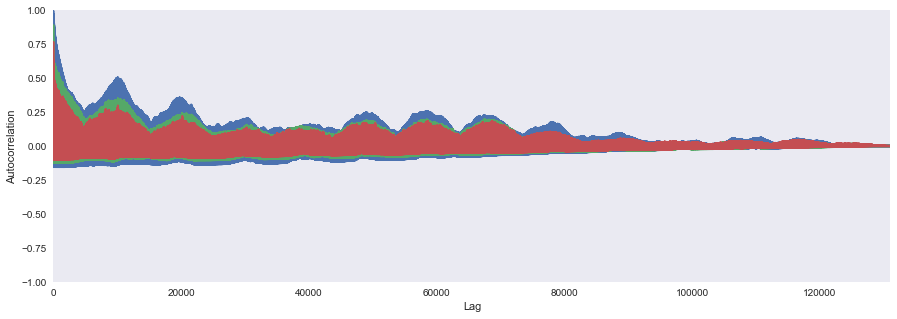

In [20]:
## Hourly resampled means
plt.figure(figsize=(15,5))
pd.plotting.autocorrelation_plot(hourlycpu);
#pd.plotting.autocorrelation_plot(hourlyreceive);
#pd.plotting.autocorrelation_plot(hourlytransmit);

## Is CPU Capacity Ever Met? If so, how often?

In [21]:
print("The Average CPU Percent Usage is only: " + str(round(concatenated_df['CPU usage [%]'].mean(),2)) + "%!!")
print("The Minimum CPU Percent Usage is: " + str(round(concatenated_df['CPU usage [%]'].min(),2)) + "%!!")
print("The Maximum CPU Percent Usage is: " + str(round(concatenated_df['CPU usage [%]'].max(),2)) + "%, possibly inidcating the system crashed?")

The Average CPU Percent Usage is only: 6.01%!!
The Minimum CPU Percent Usage is: 0.0%!!
The Maximum CPU Percent Usage is: 182.13%, possibly inidcating the system crashed?


## Create DF with standardized z scores - didn't use this for models
## converting hourlydat --> standardizeddf 

In [32]:
from scipy.stats import zscore
#remove first row with NA's from previous shift, that way we can get z scores
standardizeddf = hourlydat.iloc[1:]
standardizeddf = standardizeddf.apply(zscore) 

In [33]:
#list(standardizeddf.columns.values)
#standardizeddf = standardizeddf[['CPU usage [MHZ]', 'CPU usage [%]','Memory usage [KB]', 'Disk read throughput [KB/s]', 'Disk write throughput [KB/s]', 'Network received throughput [KB/s]', 'Network transmitted throughput [KB/s]','CPU capacity provisioned [MHZ]','Memory capacity provisioned [KB]','CPU usage prev', 'CPU_diff', 'received_prev', 'received_diff','transmitted_prev', 'transmitted_diff', 'weekday', 'weekend', 'month', 'day','CPU cores']]

### Importing metrics 

In [22]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Plot moving averages, window = 24 (hours in a day). looks like this caught some anomalies

In [23]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])


In [24]:
## FUNCTION TO PLOT MOVING AVG
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bound / Lower Boud")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

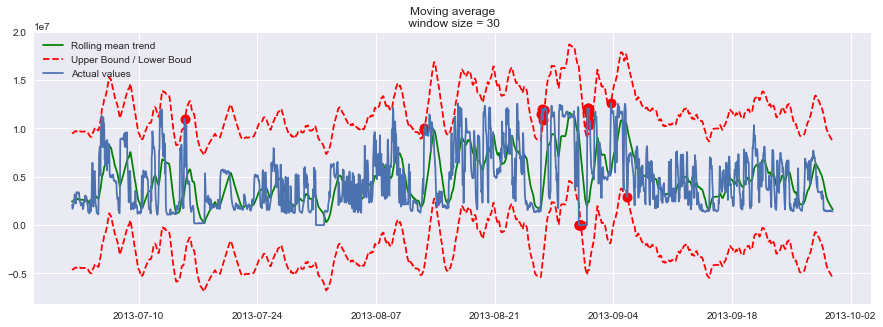

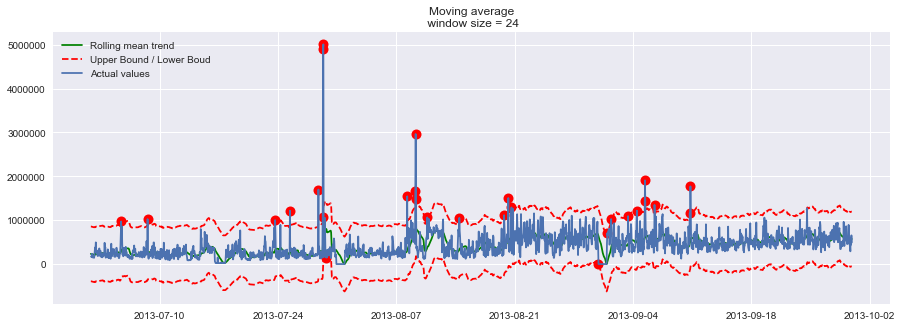

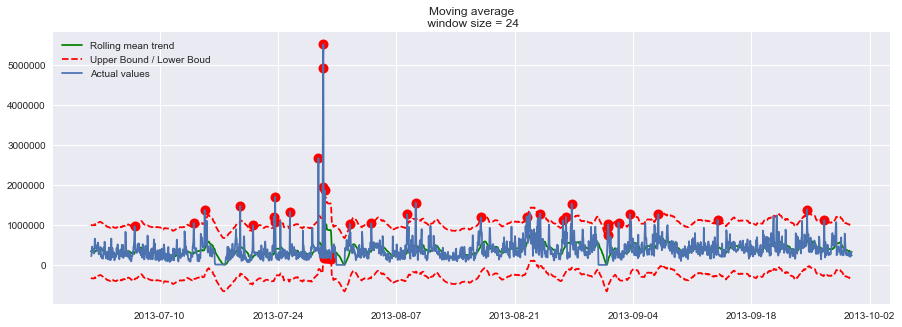

In [26]:
## make 24 hour windows
plotMovingAverage(hourlydat[['CPU usage [MHZ]']], 30, plot_intervals=True, plot_anomalies=True)

plotMovingAverage(hourlydat[['Network received throughput [KB/s]']], 24, plot_intervals=True, plot_anomalies=True)

plotMovingAverage(hourlydat[['Network transmitted throughput [KB/s]']], 24, plot_intervals=True, plot_anomalies=True)

# Establish Stationarity 
## Difference data to help establish stationarity (an assumption in time series)

## Augmented Dickey-Fuller Test (description from: [this blog](https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-9-time-series-analysis-in-python-a270cb05e0b3))

Time Series models are described in terms of autoregressive (AR) lags. So an AR(1) model states that the value at Yt depends on the value at Yt-1. So we can represent the time series as a model:

Yt = Alpha + Rho*Yt-1 + Errort

time series is perfectly stationary when Rho = 0. This makes intuitive sense: The time series will not depend on its previous value when Rho is 0, so it depends entirely on error and is equivalent to a random walk. A time series is perfectly non-stationary if Rho = 1. Alpha is a coeffecient that we want to estimate such that the Error term is minimized.

The Dickey-Fuller Test asks if Rho in an AR(1) model is equal to 0 (H0: Rho=1, H1: Rho<1)

The augmented Dickey-Fuller Test just expands this to work for AR(n) models

A p-value < 0.05 indicates that your time series IS STATIONARY.

In [27]:
from statsmodels.tsa.stattools import adfuller

## ADF test looking at CPU - CPU usage looks to be stationary p < .05

In [28]:
dftest = adfuller(hourlydat['CPU usage [MHZ]'], autolag='AIC')

# formats stats output
def adf_output(dftest):
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# of Lags Used','Number of Observations Used'])

    # the last element is a dictionary to unpack
    for key,value in dftest[4].items(): 
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
adf_output(dftest)

Test Statistic                -6.633146e+00
p-value                        5.648578e-09
# of Lags Used                 1.200000e+01
Number of Observations Used    2.171000e+03
Critical Value (1%)           -3.433366e+00
Critical Value (5%)           -2.862872e+00
Critical Value (10%)          -2.567479e+00
dtype: float64


Test Statistic                -1.779734e+01
p-value                        3.228679e-30
# of Lags Used                 1.200000e+01
Number of Observations Used    2.170000e+03
Critical Value (1%)           -3.433367e+00
Critical Value (5%)           -2.862873e+00
Critical Value (10%)          -2.567480e+00
dtype: float64


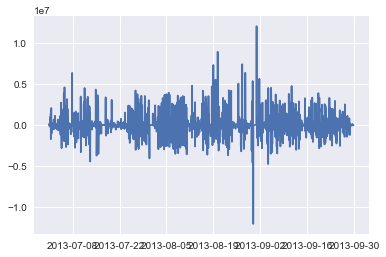

In [31]:
### look at difference 
diffed = hourlydat['CPU usage [MHZ]'] - hourlydat['CPU usage [MHZ]'].shift()
diffed.dropna(inplace=True)
plt.plot(diffed)
sns.despine()
diffed_adf = adfuller(diffed, autolag='AIC')
adf_output(diffed_adf)

Check autocorrelation in data- looks like we have a short term time series

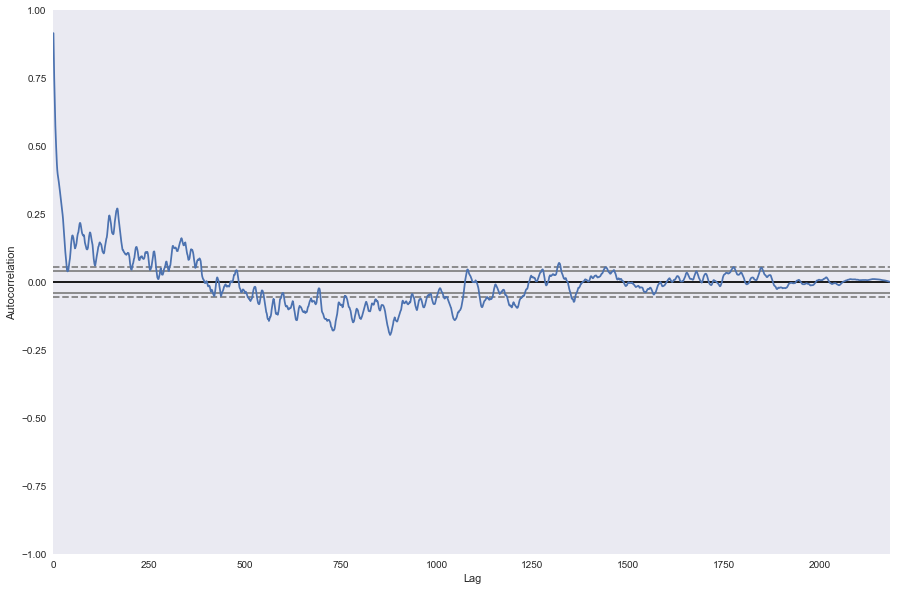

In [78]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from pandas.tools.plotting import autocorrelation_plot
plt.figure(figsize=(15,10))
autocorrelation_plot(hourlydat['CPU usage [MHZ]'])
plt.show()

# MODELING

## Simple ARIMA model

                             ARIMA Model Results                              
Dep. Variable:      D.CPU usage [MHZ]   No. Observations:                 2183
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -33813.757
Method:                       css-mle   S.D. of innovations        1290613.118
Date:                Sat, 23 Jun 2018   AIC                          67641.514
Time:                        22:52:27   BIC                          67681.333
Sample:                    06-30-2013   HQIC                         67656.070
                         - 09-29-2013                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    -116.4533   2.28e+04     -0.005      0.996   -4.49e+04    4.47e+04
ar.L1.D.CPU usage [MHZ]     0.0061      0.021      0.284      0.777      -0.036       0.048


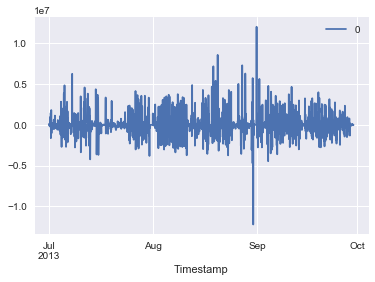

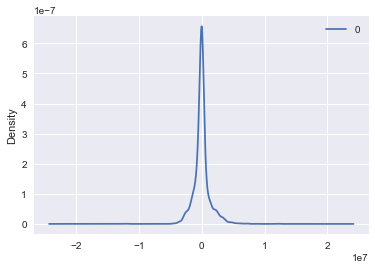

                  0
count  2.183000e+03
mean   2.226193e+00
std    1.290909e+06
min   -1.221676e+07
25%   -4.599270e+05
50%   -2.813321e+04
75%    2.954918e+05
max    1.203131e+07


In [49]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot

def parser(x):
    return datetime.strptime('20'+x, '%Y-%m')

# fit model
model = ARIMA(hourlydat['CPU usage [MHZ]'], order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe()) ### pretty close to 0

# coef for lags 1-3 are significant

### create predicted vs expected values to plot ARIMA

takes a long time

In [74]:
from pandas import datetime
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
 

X = hourlydat['CPU usage [MHZ]']
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(10,0,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)


predicted=240746.708662, expected=226825.270895
predicted=239572.836549, expected=227796.580547
predicted=240491.534883, expected=226694.440661
predicted=239378.141790, expected=230401.081331
predicted=242780.678517, expected=214641.093410
predicted=228390.458029, expected=211365.632636
predicted=225208.230472, expected=210122.974683
predicted=224007.426584, expected=210108.202208
predicted=223136.032125, expected=208850.501280
predicted=222309.474832, expected=217897.479422
predicted=230708.601264, expected=210407.882401
predicted=224303.976243, expected=207012.559334
predicted=220842.141654, expected=201925.778906
predicted=216986.940574, expected=363674.772764
predicted=364034.000391, expected=719526.833278
predicted=691838.982630, expected=683521.244718


KeyboardInterrupt: 

In [ ]:
testnew = test
testnew= testnew.reset_index(drop = True)
prednew = pd.Series( (v[0] for v in predictions) )
#prednew.head()

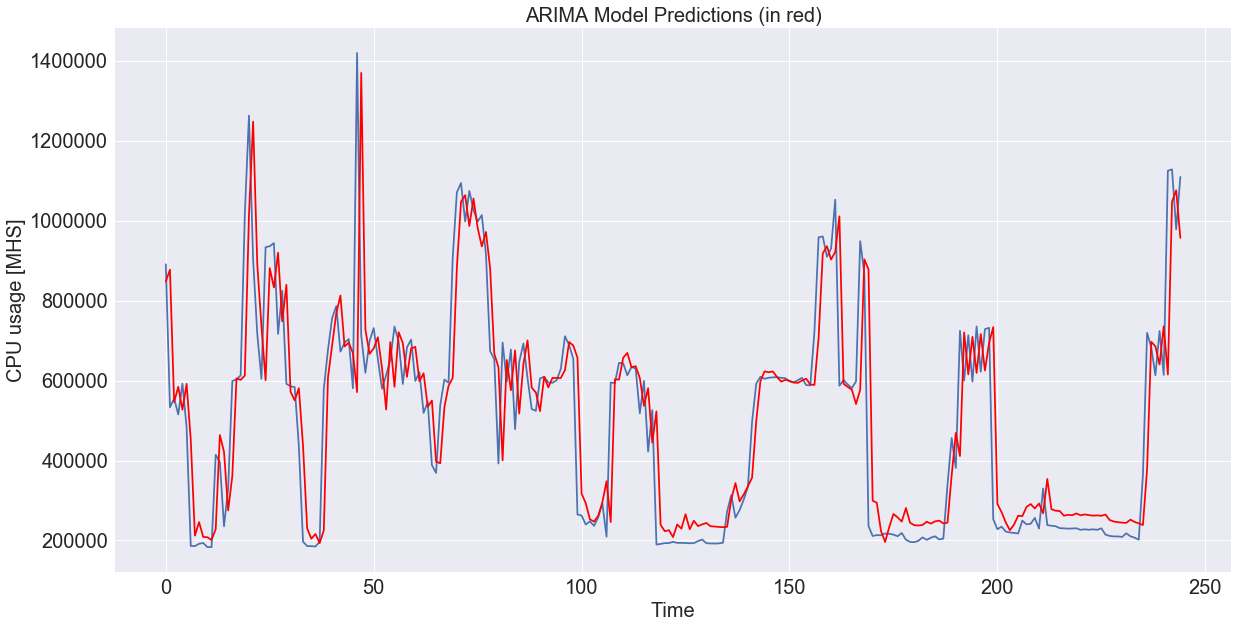

In [52]:
plt.figure(figsize=(20,10))
plt.plot(testnew)
plt.plot(prednew, color='red')
plt.tick_params(labelsize=20)
plt.title("ARIMA Model Predictions (in red)", fontsize = 20)
plt.ylabel("CPU usage [MHS]", fontsize = 20)
plt.xlabel("Time", fontsize = 20)
plt.show();


## Test Stationarity 

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [53]:
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

stopped working when I added in more data... model wasn't great before, though. might have to do with how much data I am leaving for testing??

# Modeling! 

load function for ts train test split

In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [56]:
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

### Create copy of hourlydat

In [64]:
data = pd.DataFrame(hourlydat['CPU usage [MHZ]'].copy())
data.columns = ["y"]

# Adding the lag of the target variable from 3 steps back up to 24
for i in range(3, 25):
    data["lag_{}".format(i)] = data.y.shift(i)

In [65]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

In [67]:
hourlydat.head()

,Timestamp [ms],CPU cores,CPU capacity provisioned [MHZ],CPU usage [MHZ],CPU usage [%],Memory capacity provisioned [KB],Memory usage [KB],Disk read throughput [KB/s],Disk write throughput [KB/s],Network received throughput [KB/s],...,weekday,weekend,month,day,CPU usage prev,CPU_diff,received_prev,received_diff,transmitted_prev,transmitted_diff
Timestamp,,,,,,,,,,,,,,,,,,,,,
2013-06-30 22:00:00,7000420415400,14040,3.812018e+07,1.677022e+06,19372.219544,4.871188e+10,1.855677e+09,7.029850e+05,4.193359e+05,183190.941026,...,30600,5100.0,30600,153000,19414.112996,-43.393452,180831.050549,2359.623810,326200.323626,16165.757143
2013-06-30 23:00:00,7000438772425,14040,3.812018e+07,1.817519e+06,21302.382630,4.871215e+10,1.805727e+09,9.123973e+05,5.972818e+05,242444.979121,...,30600,5100.0,30600,153000,21076.695130,225.687500,241262.312454,1182.666667,408959.506960,-607.066667
2013-07-01 00:00:00,7000457135400,14040,3.812018e+07,1.719936e+06,19897.298070,4.871231e+10,1.742155e+09,9.670129e+05,1.122391e+06,279554.250216,...,0,0.0,35700,5100,20141.976542,-244.678472,277536.650216,2017.600000,473957.901732,5383.866667
2013-07-01 01:00:00,7000475496903,14040,3.812018e+07,1.649799e+06,19546.600496,4.871278e+10,1.724193e+09,1.628856e+06,9.403050e+05,221960.783333,...,0,0.0,35700,5100,19328.684524,217.915972,225730.983333,-3770.200000,480794.416667,5991.133333
2013-07-01 02:00:00,7000493860500,14040,3.812018e+07,1.731963e+06,20524.195406,4.871361e+10,1.782729e+09,1.413094e+06,1.108244e+06,194033.990476,...,0,0.0,35700,5100,20509.355128,14.840278,193461.190476,572.800000,362464.440476,-15246.866667


## plotting functions

In [73]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)


In [74]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        plt.tick_params(labelsize=20)
        # plt.axhline(y= meancapacity, color='b', linestyle='--')
        plt.title("ARIMA Model Predictions (in red)", fontsize = 20)
        plt.ylabel("CPU usage [MHZ]", fontsize = 20)
        plt.xlabel("Time", fontsize = 20) 
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error),  fontsize = 20)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    


In [75]:
def plotModelResultsScaler(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    #preds = list(prediction)

    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bound / lower bound", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        #plt.axhline(y= meancapacity, color='b', linestyle='--')
        plt.tick_params(labelsize=20)
        plt.title("ARIMA Model Predictions (in red)", fontsize = 20)
        plt.ylabel("CPU usage [MHZ]", fontsize = 20)
        plt.xlabel("Time", fontsize = 20) 
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error), fontsize = 20)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    #print(preds)


## Linear Regession

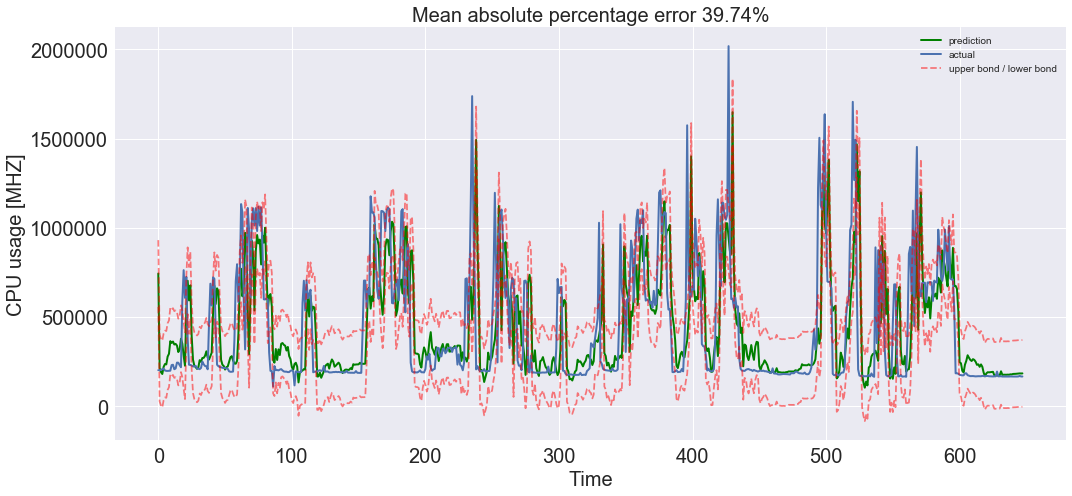

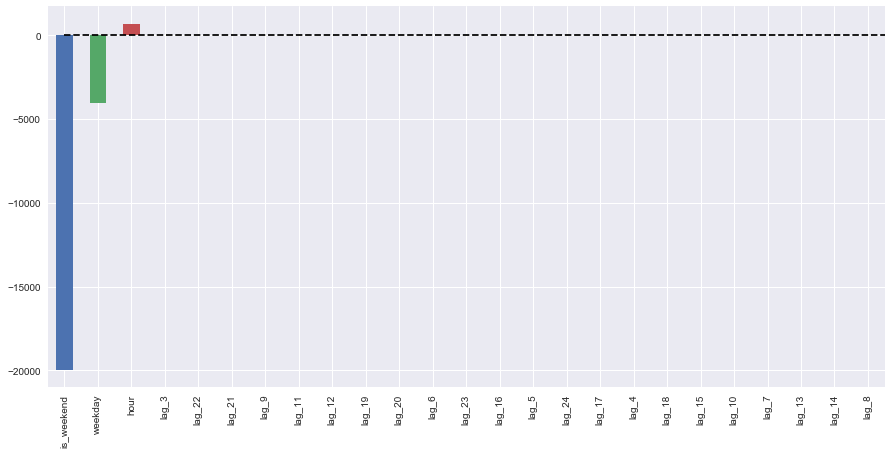

In [76]:
# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

#linear reg
lr = LinearRegression()
lr.fit(X_train, y_train)

plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

## create extra features

In [77]:
data.index = data.index.to_datetime()
data["hour"] = data.index.hour
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1

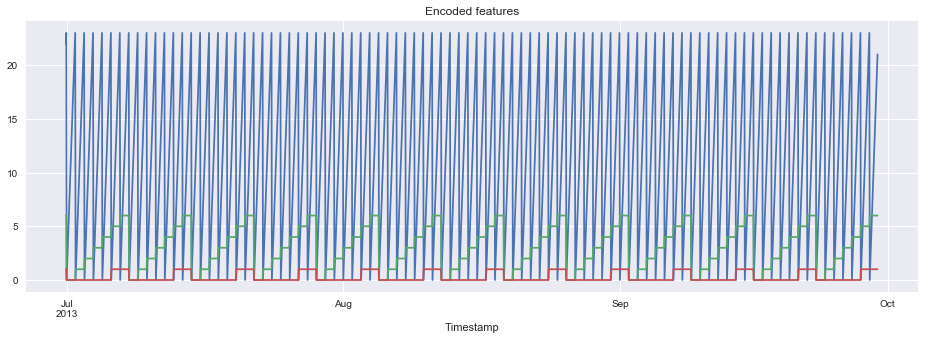

In [78]:
plt.figure(figsize=(16, 5))
plt.title("Encoded features")
data.hour.plot()
data.weekday.plot()
data.is_weekend.plot()
plt.grid(True);

## scaled linear regression with added features

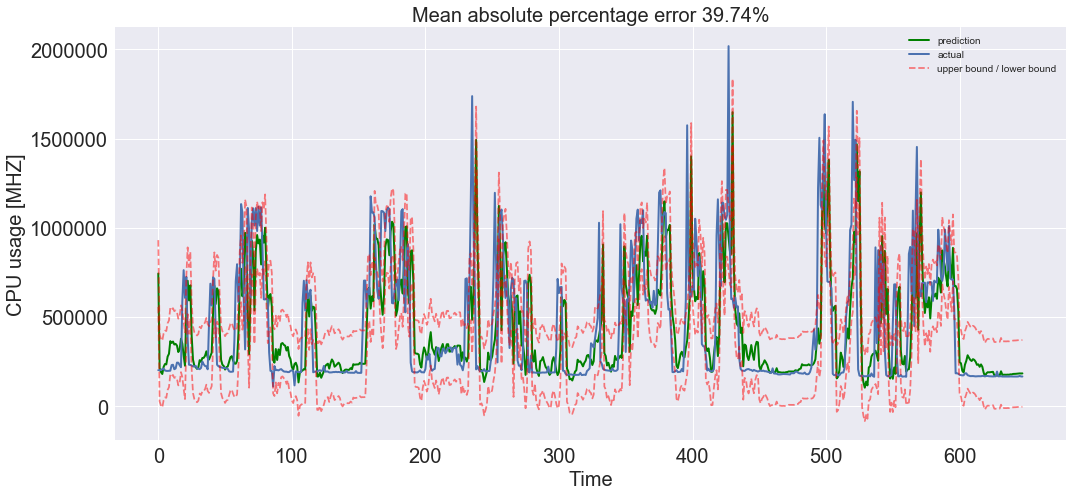

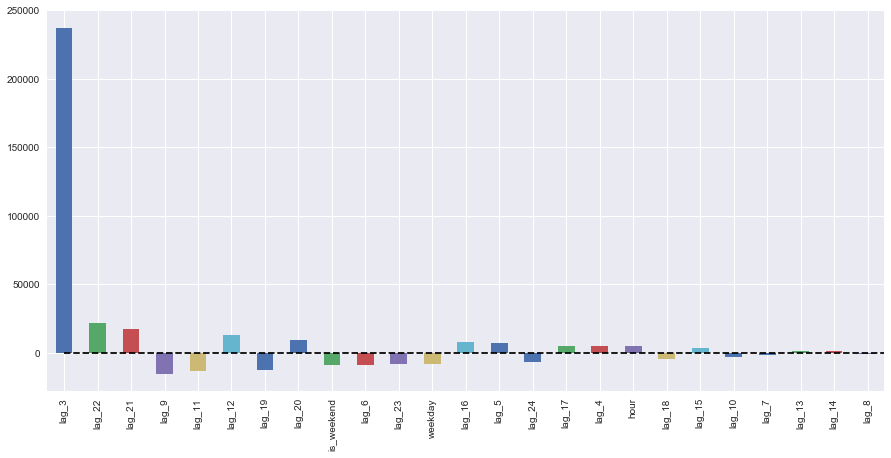

In [79]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr2 = LinearRegression()
lr2.fit(X_train_scaled, y_train)

plotModelResultsScaler(lr2, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr2)

In [80]:
def code_mean(data, cat_feature, real_feature):
    """
    Returns values- means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

## Function to prepare data for model with encoded features

In [2]:
def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries
        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today
        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today
        test_size: float
            size of the test dataset after train/test split as percentage of dataset
        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
    
    # copy of the initial dataset
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    
    # lags of series
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # datetime features
    data.index = data.index.to_datetime()
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    data['network received'] = hourlydat[['Network received throughput [KB/s]']]
    data['network transmitted'] = hourlydat[['Network transmitted throughput [KB/s]']]
    #data['cpu diff'] = hourlydat[['CPU_diff']]
    data['received_prev'] = hourlydat[['received_prev']]
    data['Memory usage [KB]'] = hourlydat[['Memory usage [KB]']]
    data['core'] = hourlydat[['CPU cores']]

    if target_encoding:
        # calculate averages on train set only
        test_index = int(len(data.dropna())*(1-test_size))
        data['weekday_average'] = list(map(
            code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
        data["hour_average"] = list(map(
            code_mean(data[:test_index], 'hour', "y").get, data.hour))
        data["weekend_average"] = list(map(
            code_mean(data[:test_index], 'is_weekend', "y").get, data.hour))
        
        # drop encoded variables 
        data.drop(["hour", "weekday", "is_weekend"], axis=1, inplace=True)
    
    # train-test split
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test =\
    timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test
  
  
X_train, X_test, y_train, y_test =\
prepareData(hourlydat[['CPU usage [MHZ]']], lag_start=3, lag_end=25, test_size=0.3, target_encoding=True)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
#overprovision.plot(figsize=(15,10))
#overprovision_scaled = scaler.transform(overprovision)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResultsScaler(lr, X_train=X_train_scaled, X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

NameError: name 'hourlydat' is not defined

In [82]:
X_train, X_test, y_train, y_test =\
prepareData(hourlydat['CPU usage [MHZ]'], lag_start=3, lag_end=25, test_size=0.3, target_encoding=False)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [1]:

plt.figure(figsize=(10, 8))
sns.heatmap(hourlydat.corr());

NameError: name 'plt' is not defined

## Ridge regression

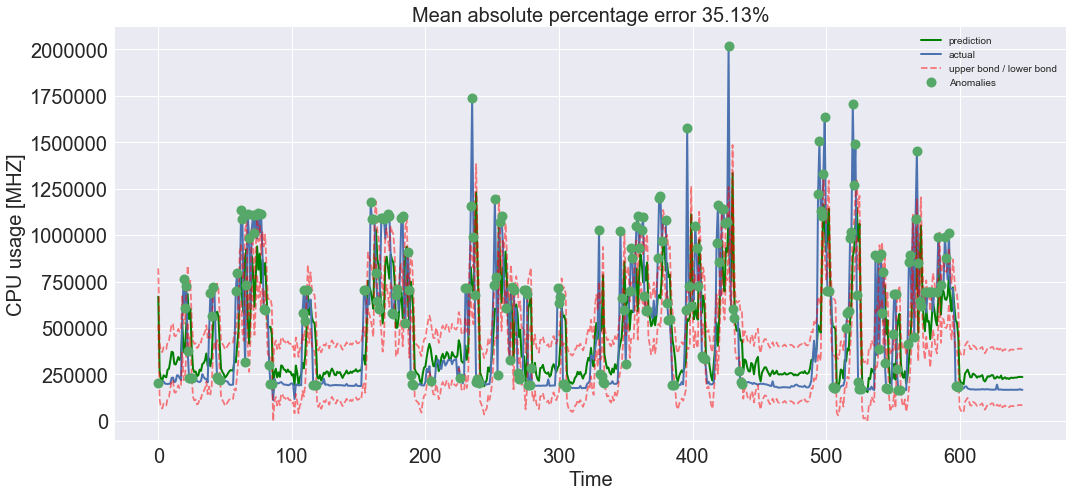

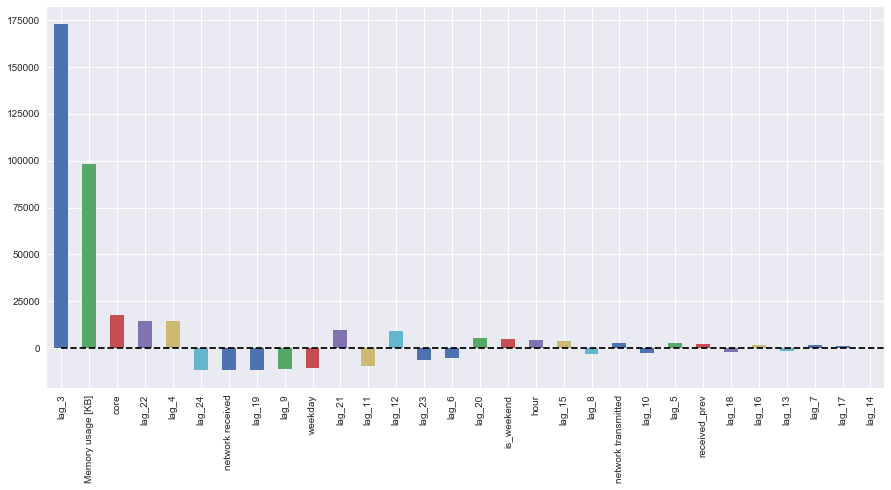

In [84]:

from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)

## Lasso regression

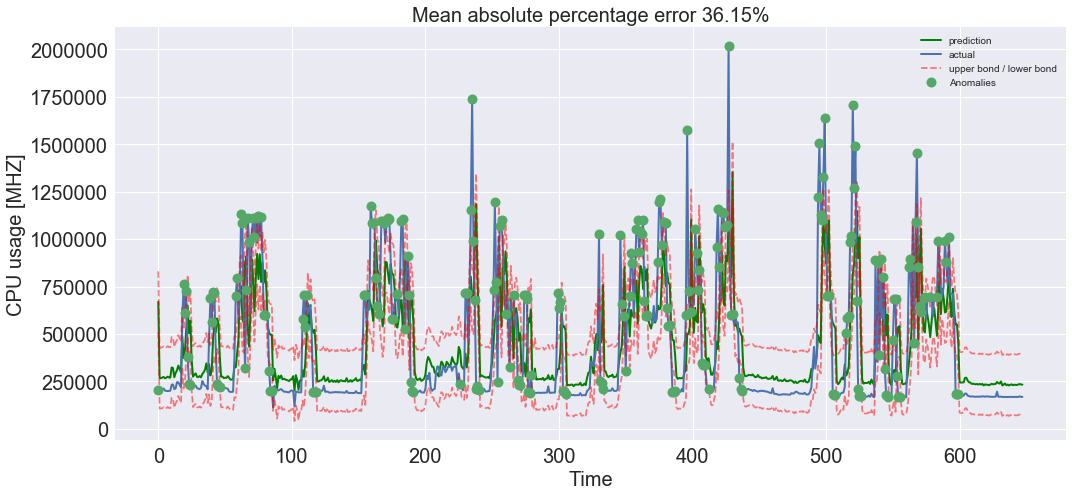

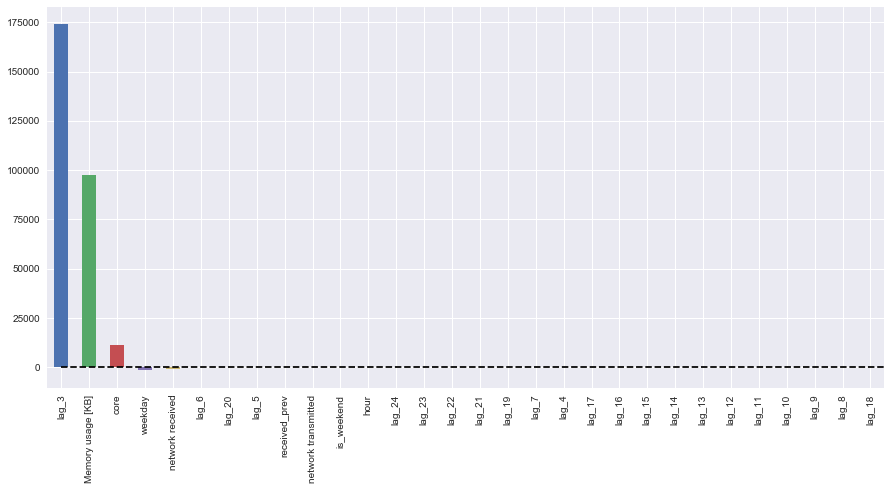

In [85]:

lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso)

# XGBOOST - will not install or run

In [86]:
#!pip install xgboost

## SARIMA MODELS - not working

In [87]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        

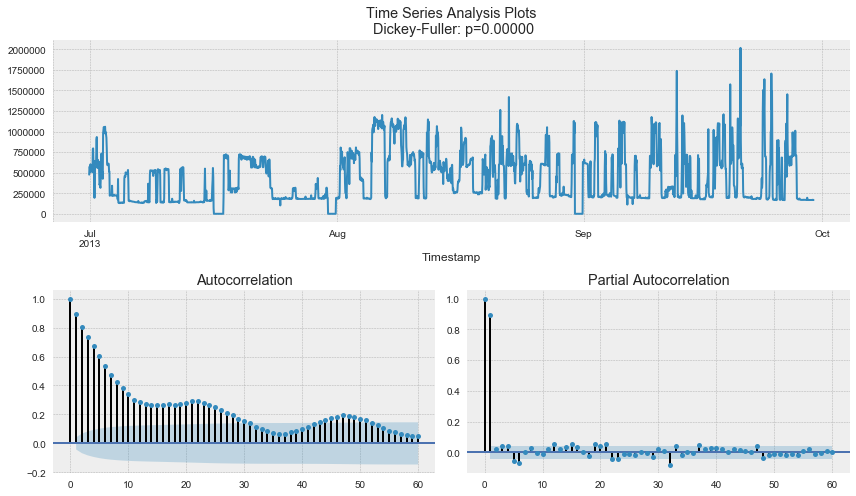

In [88]:
tsplot(hourlydat['CPU usage [MHZ]'], lags=60)

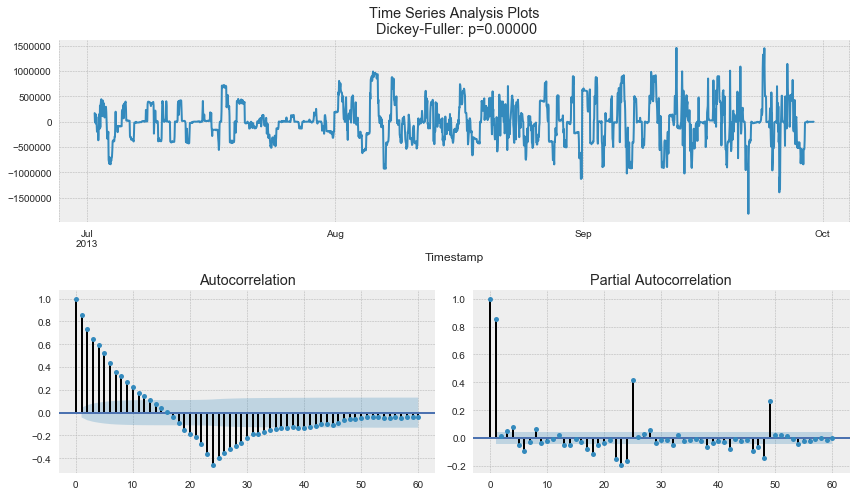

In [89]:
ads_diff = hourlydat['CPU usage [MHZ]'] - hourlydat['CPU usage [MHZ]'].shift(24)
tsplot(ads_diff[24:], lags=60)

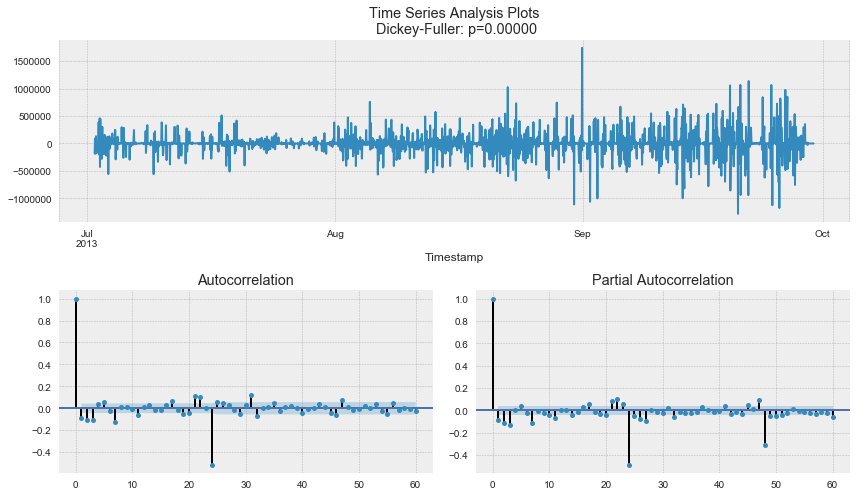

In [90]:
ads_diff = ads_diff - ads_diff.shift(1)
tsplot(ads_diff[24+1:], lags=60)

In [91]:
# setting initial values and some bounds for them based on ACF and PACF
ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 3)
D=1 
Qs = range(0, 2)
s = 24 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)


In [169]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(hourlydat['CPU usage [MHZ]'], order=(param[0], d, param[1]), 
                                            seasonal_order=(param[3], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table
    

result_table = optimizeSARIMA(parameters_list, d, D, s)


HBox(children=(IntProgress(value=0, max=54), HTML(value='')))

In [1490]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(hourlydat['CPU usage [MHZ]'], order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                    CPU usage [MHZ]   No. Observations:                  720
Model:             SARIMAX(2, 1, 4)x(2, 1, 1, 24)   Log Likelihood               -9231.978
Date:                            Thu, 14 Jun 2018   AIC                          18483.956
Time:                                    09:58:59   BIC                          18529.749
Sample:                                07-31-2013   HQIC                         18501.634
                                     - 08-30-2013                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4673     10.842      0.043      0.966     -20.783      21.718
ar.L2          0.4082      9.935   

# SARIMA ATTEMPT 2

In [93]:
import itertools

Search for optimal parameter values based on ACF/PACF values 

In [94]:
# load required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# define the p, d and q parameters to take any value between 0 and 12
p = d = q = range(0, 13)
 
# generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))
 
# generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

**Create best SARIMAX Model - TAKES A LONG WHILE TO RUN!!**

In [ ]:
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
tmp_model = None
best_mdl = None
 
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            tmp_mdl = sm.tsa.statespace.SARIMAX(y_train,
                                                order = param,
                                                seasonal_order = param_seasonal,
                                                enforce_stationarity=True,
                                                enforce_invertibility=True)
            res = tmp_mdl.fit()
            if res.aic < best_aic:
                best_aic = res.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_mdl = tmp_mdl
        except:
            #print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

## ARIMA Model Fitting 

All coefficients are significant, so we can keep them in model.

In [123]:
# define SARIMAX model and fit it to the data
mdl = sm.tsa.statespace.SARIMAX(y_train,
                                order=(0, 1, 0),
                                seasonal_order=(2, 2, 1, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
res = mdl.fit()
#The summary- look at table of coefficients.


# print statistics
print(res.aic)
print(res.summary())


39424.88765451817
                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                 1512
Model:             SARIMAX(0, 1, 0)x(2, 2, 1, 12)   Log Likelihood              -19708.444
Date:                            Sun, 17 Jun 2018   AIC                          39424.888
Time:                                    00:03:22   BIC                          39446.172
Sample:                                07-01-2013   HQIC                         39432.814
                                     - 09-02-2013                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.6327      0.025    -25.575      0.000      -0.681      -0.584
ar.S.L24      -0.

In [124]:
# fit model to data
res = sm.tsa.statespace.SARIMAX(y_train,
                                order=(0, 1, 0),
                                seasonal_order=(2,2, 1, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True).fit()
 

# SARIMAX Long-term Forecasting model- not too helpful

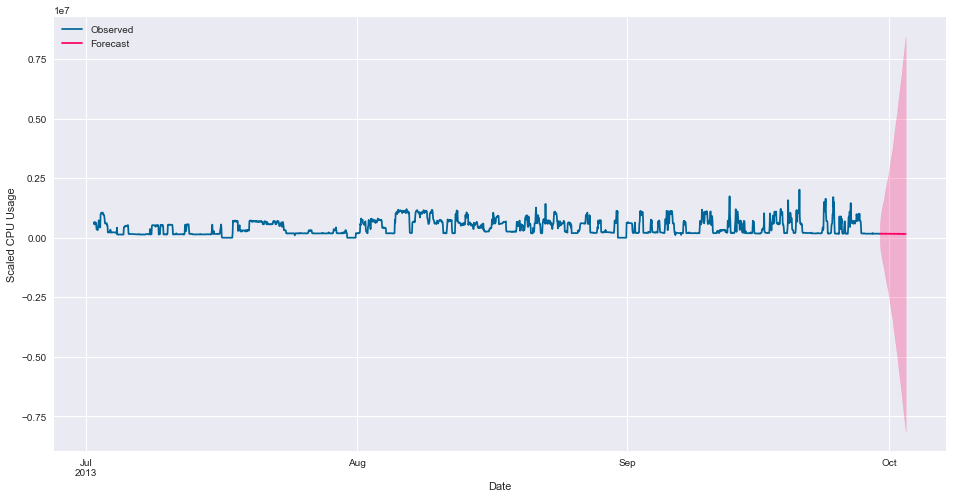

In [128]:
# build model and fit
res = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 1, 0),
                                seasonal_order=(2, 2, 1, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True).fit()
 
# get forecast 24 steps ahead in future
pred_uc = res.get_forecast(steps=72)
 
# get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()
 
# plot time series and long-term forecast
ax = y.plot(label='Observed', figsize=(16, 8), color='#006699');
pred_uc.predicted_mean.plot(ax=ax, label='Forecast', color='#ff0066');
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='#ff0066', alpha=.25);
ax.set_xlabel('Date');
ax.set_ylabel('Scaled CPU Usage');
plt.legend(loc='upper left')
plt.show()

# Neural Net Attempt

In [239]:
from sklearn.model_selection import train_test_split


# Creating a copy of the initial datagrame to make various transformations 
data = pd.DataFrame(hourlydat['CPU usage [MHZ]'].copy())
data.columns = ["y"]
data.index = data.index.to_datetime()
data["hour"] = data.index.hour
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1



y = pd.DataFrame(data.dropna().y)
X = data.dropna().drop(['y'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)




In [243]:
# use scaled train test split from above

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(30,30,30))
mlp.fit(X_train_scaled,y_train)
'''MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(30, 30, 30), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)'''

#predictions = mlp.predict(X_test)
#print(confusion_matrix(y_test,predictions))
#print(classification_report(y_test,predictions))


ValueError: Found input variables with inconsistent numbers of samples: [487, 504]